## Setup

In [1]:
import numpy as np
import pandas as pd

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import shap
shap.initjs()

%load_ext autoreload
%autoreload 1

In [2]:
class Notebook:
    OUTCOME = "CriticalEvent"



In [3]:
from evaluation import f2_score, METRICS, evaluate, evaluate_from_pred
%aimport evaluation

### Test Harness

In [4]:
from sklearn.model_selection import train_test_split


def train_test_split_notna(*frames, test_size=0.25, random_state=42):
    """ Split DataFrames or Series into random train and test subsets, such that the test subset contains no NaN values.
    """
    X = frames[0]
    mask = ~X.reset_index(drop=True).isna().any(axis=1)
    sub_size = test_size * X.shape[0] / mask.sum()

    rem_idx, test_idx = train_test_split(
        mask[mask].index, test_size=sub_size, random_state=random_state
    )
    rem_idx = np.concatenate([rem_idx, mask[~mask].index])

    return tuple(__ for _ in frames for __ in (_.iloc[rem_idx], _.iloc[test_idx]))


In [5]:
from collections import defaultdict
from sklearn.model_selection import cross_validate
from sklearn.base import clone as clone_estimator


def spotCheckDatasets(
    models, datasets, cv=3, set_params={}, order=["dataset", "model"]
):
    """ Run stratified k-fold cross-validation on the given models over the given dataset variants
        :param models: Single estimator or dict of the format {'Model Name': model}
        :param datasets: Single tuple (X, y) or dict of the format {'Dataset name': (X, y)}
        :param set_params: Hook to set model parameters based on each dataset. Callable of type function(X, y) -> Dict
    """

    models = {"Model": models} if type(models) != dict else models
    datasets = {"Data": datasets} if type(datasets) != dict else datasets

    param_callables = defaultdict(lambda: lambda X, y: dict())
    param_callables.update(set_params)

    tests = [
        (
            datakey,
            (X, y),
            modelkey,
            clone_estimator(model).set_params(**(param_callables[modelkey](X, y))),
        )
        for datakey, (X, y) in datasets.items()
        for modelkey, model in models.items()
    ]

    return (
        pd.concat(
            (
                pd.DataFrame.from_dict(
                    cross_validate(model, X=X, y=y, cv=cv, scoring=METRICS, n_jobs=-1)
                ).assign(dataset=datakey, model=modelkey)
                for datakey, (X, y), modelkey, model in tests
            )
        )
        .groupby(["dataset", "model"])
        .mean()
    )


def spotCheckCV(models, X, y, cv=3):
    """ Run stratified k-fold cross-validation on the given models
    """
    return spotCheckDatasets(models, (X, y)).loc["Data"]


def spotCheckParams(model, X, y, cv=3, fit_params={}):
    """ For more specialised models, run stratified k-fold cross-validation with fit-params
    """

    return (
        pd.DataFrame.from_dict(
            cross_validate(
                model,
                X=X,
                y=y,
                cv=cv,
                scoring=METRICS,
                n_jobs=-1,
                fit_params=fit_params,
            )
        )
        .assign(model="Model")
        .groupby("model")
        .mean()
    )


In [6]:
from sklearn.dummy import DummyClassifier


X = np.zeros((10, 5))
y = np.concatenate([np.zeros(5), np.ones(5)])
clf = DummyClassifier(strategy="constant", constant=1)
clf2 = DummyClassifier(strategy="constant", constant=1)
set_params = {"c1": lambda X, y: {"constant": 0}, "c2": lambda X, y: {"constant": 1}}

models = {"c1": clf, "c2": clf2}

spotCheckDatasets(
    datasets={"d1": (X, y), "d2": (X, y)}, models=models, set_params=set_params
)



fit_time  score_time  test_Accuracy  test_Precision  \
dataset model                                                        
d1      c1     0.000665    0.010971            0.5             0.0   
        c2     0.001662    0.008310            0.5             0.5   
d2      c1     0.000333    0.007646            0.5             0.0   
        c2     0.000333    0.006981            0.5             0.5   

               test_Recall  test_AUC  test_F1 Score  test_F2 Score  
dataset model                                                       
d1      c1             0.0       0.5       0.000000       0.000000  
        c2             1.0       0.5       0.655556       0.818903  
d2      c1             0.0       0.5       0.000000       0.000000  
        c2             1.0       0.5       0.655556       0.818903

In [7]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import clone as clone_estimator


def with_sampling_strategies(clf, clf_name="Classifier", categorical_cols_idx=[]):
    smote = (
        SMOTENC(categorical_features=categorical_cols_idx)
        if categorical_cols_idx
        else SMOTE()
    )

    return {
        f"{clf_name}_Undersampling": ImbPipeline(
            steps=[
                ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
                (clf_name, clone_estimator(clf)),
            ]
        ),
        f"{clf_name}_SMOTE": ImbPipeline(
            steps=[("smote", clone_estimator(smote)), (clf_name, clone_estimator(clf))]
        ),
        f"{clf_name}_OverUnder": ImbPipeline(
            steps=[
                ("smote", clone_estimator(smote).set_params(sampling_strategy=0.1)),
                ("undersampling", RandomUnderSampler(sampling_strategy=0.5)),
                (clf_name, clone_estimator(clf)),
            ]
        ),
        f"{clf_name}_SMOTE-Tomek": ImbPipeline(
            steps=[
                ("smote", clone_estimator(smote).set_params(sampling_strategy="auto")),
                ("tomek", TomekLinks(sampling_strategy="all")),
                (clf_name, clone_estimator(clf)),
            ]
        ),
    }


## Dataset

In [8]:
from dataset import SCIData, SCICols
%aimport dataset

#SCIData.load('data/sci.h5').clean_all().filter_vague_diagnoses().derive_readmission().omit_vbg()
sci = SCIData.load('data/sci_processed_2.h5').fix_readmissionband().derive_critical_event(within=2)

## Logistic Regression (NEWS only)

Logistic regression (L2 penalty, by default) slightly beats the baseline NEWS model, which had AUC `0.807` for this outcome, but doesn't beat the original study score of `0.873`.

Balanced variant completely flips the precision vs. recall relationship, so it does a better job of minimising false-negatives. However, the final values are still low.

In [42]:
from sklearn.linear_model import LogisticRegression

datasets_lr = {
    "Raw NEWS": sci.mandate(SCICols.news_data_raw).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float
    ),
    "Scored NEWS": sci.mandate(SCICols.news_data_scored).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_scored, dtype=float
    ),
}

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=42),
    "LR Balanced": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
}

spotCheckDatasets(models, datasets_lr)


fit_time  score_time  test_Accuracy  test_Precision  \
dataset     model                                                              
Raw NEWS    LR           1.223683    0.052070       0.984029        0.585566   
            LR Balanced  0.838566    0.057269       0.862873        0.078060   
Scored NEWS LR           0.166635    0.057272       0.983853        0.543242   
            LR Balanced  0.161397    0.057278       0.858794        0.076380   

                         test_Recall  test_AUC  test_F1 Score  test_F2 Score  
dataset     model                                                             
Raw NEWS    LR              0.057346  0.817302       0.102924       0.069666  
            LR Balanced     0.663341  0.816260       0.139240       0.263397  
Scored NEWS LR              0.051167  0.813106       0.092838       0.062354  
            LR Balanced     0.673125  0.814827       0.136870       0.261209

In [41]:
spotCheckCV(
    {
        "LR": LogisticRegression(max_iter=1000, random_state=42),
        **with_sampling_strategies(
            LogisticRegression(max_iter=1000, random_state=42), "LR"
        ),
    },
    *datasets_lr["Raw NEWS"]
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LR,1.119578,0.046862,0.984029,0.585566,0.057346,0.817302,0.102924,0.069666
LR_OverUnder,0.377455,0.062474,0.899269,0.093577,0.579545,0.817639,0.160453,0.281847
LR_SMOTE,2.301809,0.057277,0.870814,0.081415,0.649868,0.816696,0.144162,0.268844
LR_SMOTE-Tomek,7.423137,0.062485,0.870959,0.081996,0.654859,0.817389,0.145234,0.270959
LR_Undersampling,0.197884,0.046862,0.975000,0.247676,0.222929,0.818503,0.227189,0.222733


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    *sci.mandate(SCICols.news_data_raw).xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float
    ), test_size=0.33
)


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.859959,0.077025,0.678988,0.816716,0.138355,0.264916


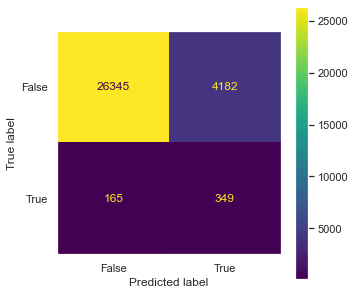

In [12]:
evaluate(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
        X_train, y_train
    ),
    X_test,
    y_test,
)


### Calibrating

The baseline model's pre-defined risk ratio (NEWS score $\geq 7$) yields its own precision and recall "ratio". I.e., it balances false-positives and negatives in a certain way. We can emulate this tradeoff by adjusting the class threshold in the regression model. 

In [13]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score


def get_news_target_ratio(X, y):
    y_pred = X.c_NEWS_score >= 7
    p = precision_score(y, y_pred)
    r = recall_score(y, y_pred)
    print(f"NEWS Precision={p:.5f}, Recall={r:.5f}")
    return p / r


# Get the "target" ratio of precision/recall that the NEWS threshold produces
target_ratio = get_news_target_ratio(
    *sci.mandate(SCICols.news_data_raw).xy(outcome=Notebook.OUTCOME)
)

# Train the LR model
model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000).fit(
    X_train, y_train
)

# Get candidate thresholds from the model, and find the one that gives the ratio closest to the target
precision, recall, thresholds = precision_recall_curve(
    y_train, model.predict_proba(X_train)[:, 1]
)
closest = thresholds[
    np.abs(
        np.divide(precision, recall, out=np.ones_like(recall), where=recall != 0)
        - target_ratio
    ).argmin()
]



NEWS Precision=0.22975, Recall=0.26733


On the test set, this gives much improved F2, while the AUC remains consistent (slightly better than baseline model).

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.972714,0.220168,0.254864,0.816716,0.236249,0.247077


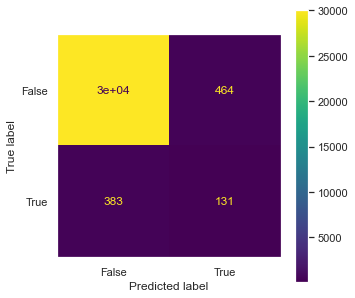

In [14]:
# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:, 1] > closest, 1, 0)

# Produce scores
evaluate_from_pred(y_test, y_pred, y_pred_proba)


## XGBoost

### Dataset Variants

In [219]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
)

datasets_xgb = {
    "Mandated vitals, One-hot diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .impute_blood()
        .augment_hsmr()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Imputed vitals, One-hot diagnoses": (
        scii.impute_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Missing NEWS, imputed blood, One-hot diagnoses": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
    "Missing blood & NEWS, One-hot diagnoses": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME)
    ),
}


In [11]:
from xgboost import XGBClassifier

models = {
    "XGB": XGBClassifier(
        tree_method="approx", enable_categorical=True, scale_pos_weight=1
    ),
    "XGB_Balanced": XGBClassifier(
        tree_method="approx",
        enable_categorical=True,
        scale_pos_weight=round(scii.shape[0] / scii[Notebook.OUTCOME].sum()),
    ),
}


In [12]:
spotCheckDatasets(datasets=datasets_xgb, models=models)


fit_time  \
dataset                                        model                     
Imputed vitals, One-hot diagnoses              XGB           29.830950   
                                               XGB_Balanced  29.684040   
Mandated vitals, Categorical diagnoses         XGB            7.698164   
                                               XGB_Balanced   7.714239   
Mandated vitals, One-hot diagnoses             XGB            9.029628   
                                               XGB_Balanced   7.674125   
Missing NEWS, imputed blood, One-hot diagnoses XGB           29.529616   
                                               XGB_Balanced  28.376553   
Missing blood & NEWS, One-hot diagnoses        XGB           29.572152   
                                               XGB_Balanced  28.282506   

                                                             score_time  \
dataset                                        model                      
Imputed vitals, One-hot diagnoses              XGB             1.046440   
                                               XGB_Balanced    1.088280   
Mandated vitals, Categorical diagnoses         XGB             0.255149   
                                               XGB_Balanced    0.245128   
Mandated vitals, One-hot diagnoses             XGB             0.265571   
                                               XGB_Balanced    0.265561   
Missing NEWS, imputed blood, One-hot diagnoses XGB             1.184813   
                                               XGB_Balanced    1.150363   
Missing blood & NEWS, One-hot diagnoses        XGB             1.182752   
                                               XGB_Balanced    1.132573   

                                                             test_Accuracy  \
dataset                                        model                         
Imputed vitals, One-hot diagnoses              XGB                0.983984   
                                               XGB_Balanced       0.941147   
Mandated vitals, Categorical diagnoses         XGB                0.982981   
                                               XGB_Balanced       0.979201   
Mandated vitals, One-hot diagnoses             XGB                0.982851   
                                               XGB_Balanced       0.979204   
Missing NEWS, imputed blood, One-hot diagnoses XGB                0.977147   
                                               XGB_Balanced       0.833821   
Missing blood & NEWS, One-hot diagnoses        XGB                0.977147   
                                               XGB_Balanced       0.833821   

                                                             test_Precision  \
dataset                                        model                          
Imputed vitals, One-hot diagnoses              XGB                 0.534776   
                                               XGB_Balanced        0.160727   
Mandated vitals, Categorical diagnoses         XGB                 0.479296   
                                               XGB_Balanced        0.356120   
Mandated vitals, One-hot diagnoses             XGB                 0.481576   
                                               XGB_Balanced        0.360943   
Missing NEWS, imputed blood, One-hot diagnoses XGB                 0.223835   
                                               XGB_Balanced        0.063407   
Missing blood & NEWS, One-hot diagnoses        XGB                 0.223835   
                                               XGB_Balanced        0.063407   

                                                             test_Recall  \
dataset                                        model                       
Imputed vitals, One-hot diagnoses              XGB              0.174414   
                                               XGB_Balanced     0.602162   
Mandated vitals, Categorical diagnoses         XGB              0.143763   
      

### Resampling

In [205]:
dataset = datasets_xgb["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = dataset[0].describe_categories()[0]
spotCheckCV(
    {
        "XGB": XGBClassifier(
            tree_method="approx", enable_categorical=True, scale_pos_weight=1
        ),
        **with_sampling_strategies(
            XGBClassifier(
                tree_method="approx", enable_categorical=True, scale_pos_weight=1
            ),
            "XGB",
            categorical_cols_idx,
        ),
    },
    *dataset
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB,8.464761,0.219441,0.982939,0.491059,0.172549,0.918535,0.254046,0.197877
XGB_OverUnder,6.258998,0.231457,0.975028,0.338770,0.492810,0.925624,0.400096,0.450408
XGB_SMOTE,26.800439,0.213492,0.982608,0.465837,0.185621,0.917739,0.264635,0.210744
XGB_SMOTE-Tomek,176.183615,0.218699,0.983072,0.499651,0.193464,0.914086,0.278751,0.220431
XGB_Undersampling,1.915797,0.226580,0.972995,0.314879,0.503268,0.932294,0.385834,0.447894


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.97308,0.332589,0.59127,0.935186,0.425714,0.511676


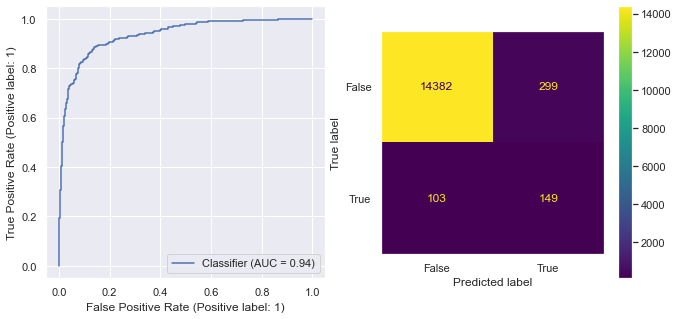

In [46]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X, y = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .encode_ccs_onehot()
    .xy(
        outcome=Notebook.OUTCOME, dropna=True, ordinal_encoding=True
    )  # Use ordinal encoding because of bug in XGB that prevents use of SHAP when pd.categorical is involved
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.33
)

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        (
            "XGB",
            XGBClassifier(
                tree_method="approx", enable_categorical=True, scale_pos_weight=1
            ),
        ),
    ]
).fit(X_train, y_train)

evaluate(model, X_test, y_test)


### Explanations

<AxesSubplot:>

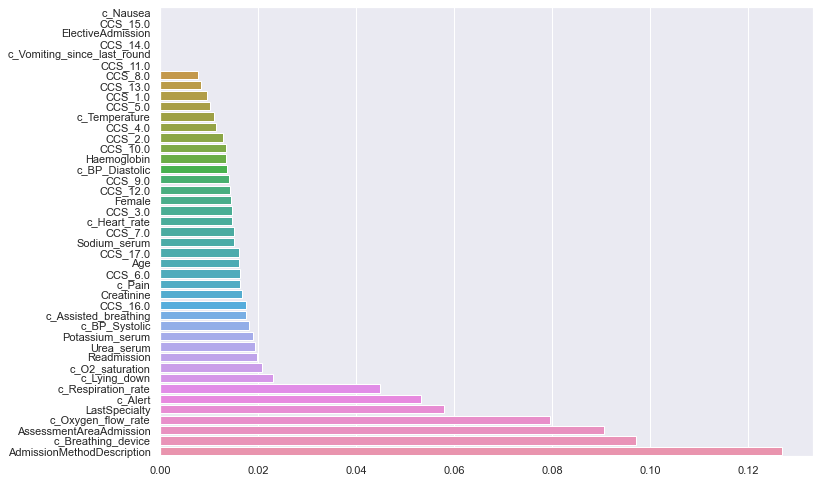

In [182]:
sorted_idx = model["XGB"].feature_importances_.argsort()
sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx], y=X_train.columns[sorted_idx]
)



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


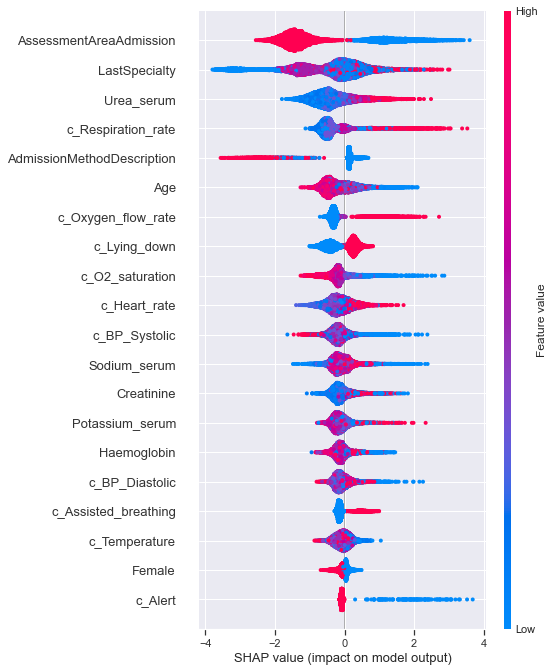

In [185]:
import shap

explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


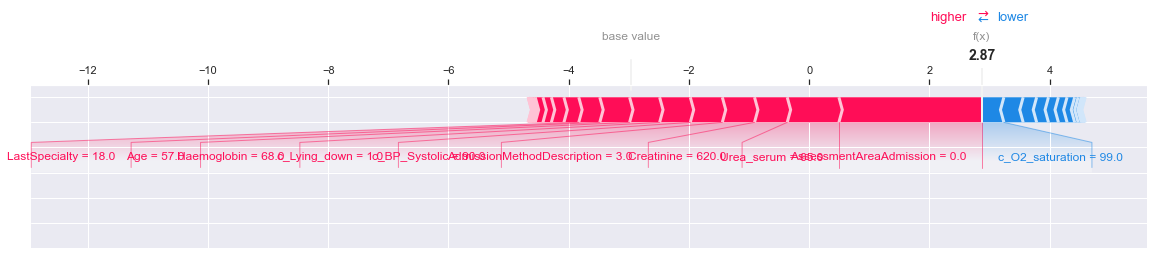

In [190]:
positive_class_idx = np.argmax(model.predict(X_test) == 1)
shap.force_plot(
    explainer.expected_value,
    shap_values[positive_class_idx, :],
    X_test.iloc[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True,
)



## Random Forest

### Dataset Variants

In [9]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
)

datasets_rf = {
    "Mandated vitals, One-hot diagnoses": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses (main only)": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .drop(SCICols.diagnoses[1:], axis=1)
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Mandated vitals, Categorical diagnoses (with missing)": (
        scii.mandate_news()
        .mandate_blood()
        .augment_hsmr()
        .drop(SCICols.diagnoses[1:], axis=1)
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
    "Imputed vitals": (
        scii.impute_news()
        .impute_blood()
        .augment_hsmr()
        .encode_ccs_onehot()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
    ),
    "Missing NEWS, imputed blood": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .mandate_diagnoses()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
    "Missing vitals": (
        scii.augment_hsmr()
        .impute_blood()
        .encode_ccs_onehot()
        .mandate_diagnoses()
        .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
    ),
}


In [193]:
from sklearn.ensemble import RandomForestClassifier

models = {
    "Random Forest": RandomForestClassifier(),
    "Random Forest (balanced)": RandomForestClassifier(
        class_weight="balanced_subsample"
    ),
}


In [196]:
spotCheckDatasets(datasets=datasets_rf, models=models)


fit_time  \
dataset                                            model                                 
Imputed vitals                                     Random Forest             32.374877   
                                                   Random Forest (balanced)  28.231448   
Mandated vitals, Categorical diagnoses (main only) Random Forest              5.992107   
                                                   Random Forest (balanced)   5.382214   
Mandated vitals, Categorical diagnoses (with mi... Random Forest              6.185508   
                                                   Random Forest (balanced)   5.818798   
Mandated vitals, One-hot diagnoses                 Random Forest              5.592132   
                                                   Random Forest (balanced)   5.286673   
Missing NEWS, imputed blood                        Random Forest             31.727418   
                                                   Random Forest (balanced)  28.596429   
Missing vitals                                     Random Forest             30.853915   
                                                   Random Forest (balanced)  33.522854   

                                                                             score_time  \
dataset                                            model                                  
Imputed vitals                                     Random Forest               3.267088   
                                                   Random Forest (balanced)    3.232579   
Mandated vitals, Categorical diagnoses (main only) Random Forest               0.577882   
                                                   Random Forest (balanced)    0.547760   
Mandated vitals, Categorical diagnoses (with mi... Random Forest               0.588403   
                                                   Random Forest (balanced)    0.602427   
Mandated vitals, One-hot diagnoses                 Random Forest               0.614255   
                                                   Random Forest (balanced)    0.555588   
Missing NEWS, imputed blood                        Random Forest               3.220292   
                                                   Random Forest (balanced)    2.973381   
Missing vitals                                     Random Forest               3.139242   
                                                   Random Forest (balanced)    3.020273   

                                                                             test_Accuracy  \
dataset                                            model                                     
Imputed vitals                                     Random Forest                  0.984025   
                                                   Random Forest (balanced)       0.983664   
Mandated vitals, Categorical diagnoses (main only) Random Forest                  0.983337   
                                                   Random Forest (balanced)       0.983359   
Mandated vitals, Categorical diagnoses (with mi... Random Forest                  0.983542   
                                                   Random Forest (balanced)       0.983477   
Mandated vitals, One-hot diagnoses                 Random Forest                  0.983337   
                                                   Random Forest (balanced)       0.983138   
Missing NEWS, imputed blood                        Random Forest                  0.984121   
                                                   Random Forest (balanced)       0.983742   
Missing vitals                                     Random Forest                  0.984067   
                                                   Random Forest (balanced)       0.983803   

                                                                             test_Precision  \
dataset                                            model                                      
Imputed vitals                     

### Resampling

In [206]:
dataset = datasets_rf["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = dataset[0].describe_categories()[0]
spotCheckCV(
    {
        "Random Forest": RandomForestClassifier(),
        **with_sampling_strategies(
            RandomForestClassifier(), "Random Forest", categorical_cols_idx
        ),
    },
    *dataset
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Random Forest,4.736428,0.618265,0.983403,0.777778,0.028758,0.901683,0.055116,0.035559
Random Forest_OverUnder,2.842353,0.562629,0.976707,0.346558,0.418301,0.921831,0.377949,0.400817
Random Forest_SMOTE,16.249758,0.609882,0.983138,0.529118,0.092810,0.914587,0.155968,0.110710
Random Forest_SMOTE-Tomek,157.830689,0.551738,0.982983,0.491494,0.086275,0.911628,0.145284,0.102979
Random Forest_Undersampling,0.981941,0.520713,0.978519,0.375624,0.390850,0.925105,0.380820,0.386224


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.975959,0.326861,0.400794,0.9091,0.360071,0.383447


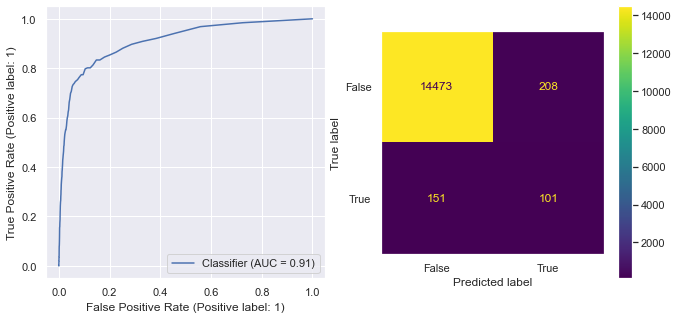

In [45]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X, y = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.33
)

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        ("randomforest", RandomForestClassifier()),
    ]
).fit(X_train, y_train)

evaluate(model, X_test, y_test)


### Explanations

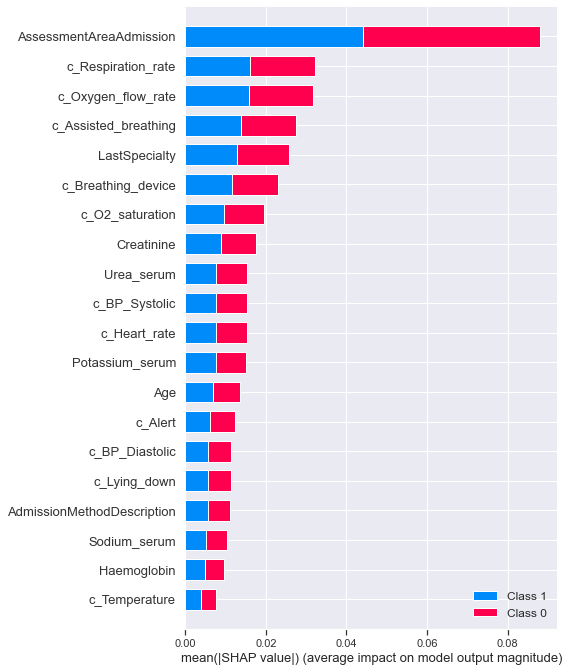

In [207]:
import shap

explainer = shap.TreeExplainer(model["randomforest"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


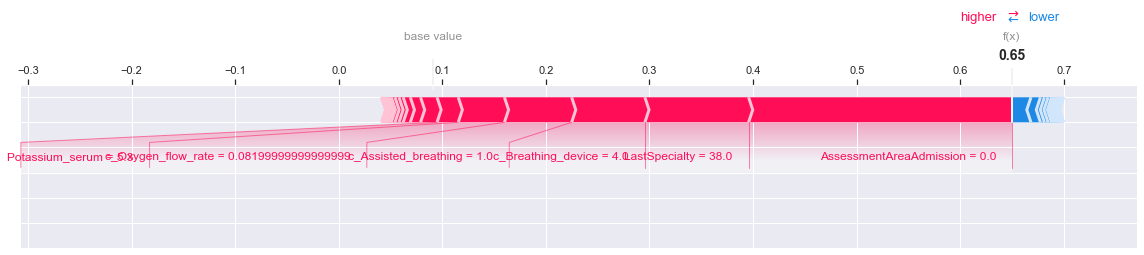

In [212]:
positive_class_idx = np.argmax(model.predict(X_test) == 1)
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][positive_class_idx, :],
    X_test.iloc[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True,
)



## Isolation Forest

### Dataset Variants

In [149]:
datasets_relabeled = {
    key: (X, y.map({True: -1, False: 1})) for key, (X, y) in datasets_rf.items()
}


In [150]:
from sklearn.ensemble import IsolationForest

models = {
    "Isolation Forest": IsolationForest(),
    "Isolation Forest (contamination)": IsolationForest(),
}
isolation_forest_set_params = {
    "Isolation Forest (contamination)": lambda X, y: dict(
        contamination=((y == -1).sum()) / y.shape[0]
    )
}


In [151]:
spotCheckDatasets(
    datasets=datasets_relabeled, models=models, set_params=isolation_forest_set_params
)



fit_time  \
dataset                                            model                                         
Imputed vitals                                     Isolation Forest                   6.111538   
                                                   Isolation Forest (contamination)  16.431637   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                   1.299782   
                                                   Isolation Forest (contamination)   3.327543   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                   1.268111   
                                                   Isolation Forest (contamination)   3.572834   
Mandated vitals, One-hot diagnoses                 Isolation Forest                   1.904223   
                                                   Isolation Forest (contamination)   4.695935   
Missing NEWS, imputed blood                        Isolation Forest                   6.102863   
                                                   Isolation Forest (contamination)  17.313430   
Missing vitals                                     Isolation Forest                   6.132557   
                                                   Isolation Forest (contamination)  16.432423   

                                                                                     score_time  \
dataset                                            model                                          
Imputed vitals                                     Isolation Forest                   10.101317   
                                                   Isolation Forest (contamination)   10.027778   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                    2.218468   
                                                   Isolation Forest (contamination)    2.042187   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                    2.266012   
                                                   Isolation Forest (contamination)    2.324591   
Mandated vitals, One-hot diagnoses                 Isolation Forest                    2.825398   
                                                   Isolation Forest (contamination)    2.852366   
Missing NEWS, imputed blood                        Isolation Forest                   10.526744   
                                                   Isolation Forest (contamination)   10.079133   
Missing vitals                                     Isolation Forest                   10.220827   
                                                   Isolation Forest (contamination)    9.973273   

                                                                                     test_Accuracy  \
dataset                                            model                                             
Imputed vitals                                     Isolation Forest                       0.900279   
                                                   Isolation Forest (contamination)       0.967527   
Mandated vitals, Categorical diagnoses (main only) Isolation Forest                       0.918034   
                                                   Isolation Forest (contamination)       0.972111   
Mandated vitals, Categorical diagnoses (with mi... Isolation Forest                       0.909806   
                                                   Isolation Forest (contamination)       0.972354   
Mandated vitals, One-hot diagnoses                 Isolation Forest                       0.883515   
                                                   Isolation Forest (contamination)       0.968796   
Missing NEWS, imputed blood                        Isolation Forest                       0.835086   
                                                   Isolation Forest (contamination)       0.966325   
Missing vitals                                     Isolation Forest                       0.823355   


### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.970679,0.985735,0.984423,0.837621,0.985079,0.984685


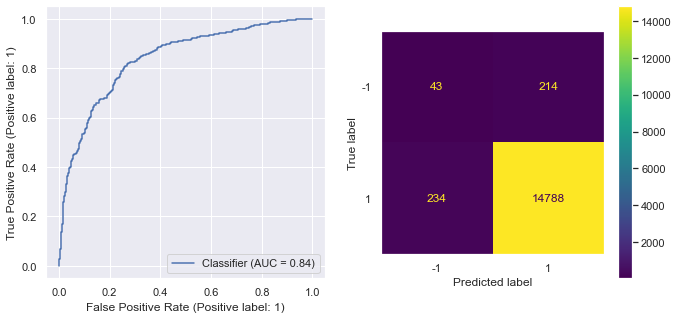

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

X, y = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .drop(SCICols.diagnoses[1:], axis=1)
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True)
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.33
)

model = IsolationForest(contamination=y_train.sum() / y_train.shape[0]).fit(
    X_train.to_numpy()
)
evaluate(model, X_test.to_numpy(), y_test.map({True: -1, False: 1}))


### Explanations

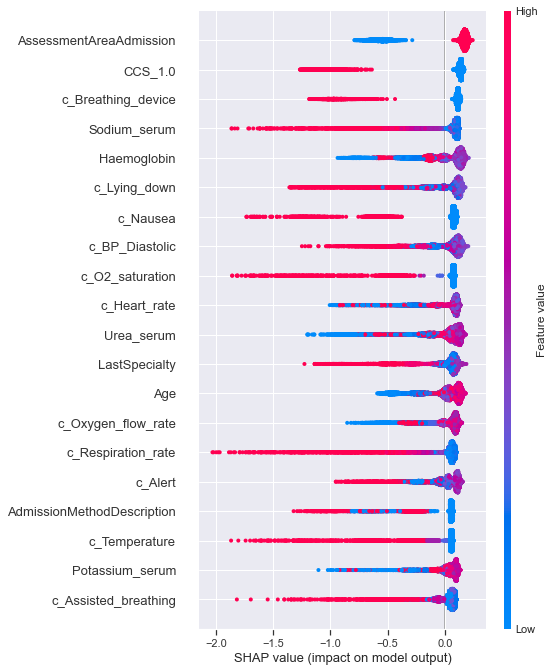

In [166]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


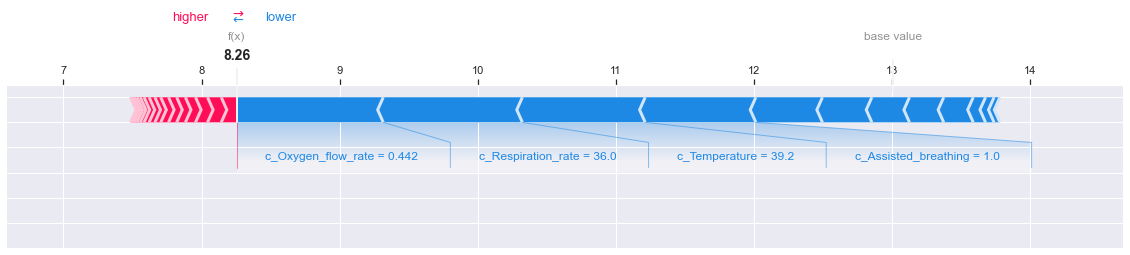

In [170]:
positive_class_idx = np.argmax(model.predict(X_test) == -1)
shap.force_plot(
    explainer.expected_value,
    shap_values[positive_class_idx, :],
    X_test.iloc[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True,
)



## Other Boosters

In [222]:
from sklearn.ensemble import HistGradientBoostingClassifier

spotCheckDatasets(
    datasets=datasets_rf, models={"HGBC": HistGradientBoostingClassifier()}
)



,,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
dataset,model,,,,,,,,
Imputed vitals,HGBC,4.668573,0.866901,0.982937,0.452066,0.165665,0.921638,0.237520,0.188180
"Mandated vitals, Categorical diagnoses (main only)",HGBC,1.105510,0.203077,0.982365,0.463049,0.197386,0.930802,0.273320,0.221843
"Mandated vitals, Categorical diagnoses (with missing)",HGBC,0.989350,0.197870,0.982527,0.460243,0.186130,0.924723,0.262126,0.210357
"Mandated vitals, One-hot diagnoses",HGBC,1.958991,0.250155,0.982320,0.441434,0.176471,0.930894,0.249172,0.199620
"Missing NEWS, imputed blood",HGBC,5.112328,0.919092,0.983778,0.514505,0.176369,0.924585,0.258372,0.201786
Missing vitals,HGBC,4.868209,0.859130,0.983460,0.485691,0.172309,0.922941,0.249963,0.196528


### LightGBM

In [227]:
from lightgbm import LGBMClassifier

spotCheckDatasets(
    datasets=datasets_xgb, models={"LightGBM": LGBMClassifier(metric=["l2", "auc"])}
)



,,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
dataset,model,,,,,,,,
"Imputed vitals, One-hot diagnoses",LightGBM,2.713002,1.924658,0.983668,0.503254,0.188108,0.926366,0.269377,0.213637
"Mandated vitals, Categorical diagnoses",LightGBM,0.702146,0.475537,0.982441,0.439780,0.168132,0.928860,0.241435,0.191245
"Mandated vitals, One-hot diagnoses",LightGBM,0.695968,0.400943,0.982254,0.438488,0.190850,0.933296,0.264404,0.214622
"Missing NEWS, imputed blood, One-hot diagnoses",LightGBM,3.031069,1.910914,0.983879,0.524185,0.200360,0.928235,0.283068,0.226393
"Missing blood & NEWS, One-hot diagnoses",LightGBM,2.917510,1.931619,0.983879,0.524185,0.200360,0.928235,0.283068,0.226393


In [228]:
dataset = datasets_xgb["Mandated vitals, One-hot diagnoses"]
categorical_cols_idx = dataset[0].describe_categories()[0]
spotCheckCV(
    {
        "LightGBM": LGBMClassifier(metric=["l2", "auc"]),
        **with_sampling_strategies(
            LGBMClassifier(metric=["l2", "auc"]), "LightGBM", categorical_cols_idx
        ),
    },
    *dataset
)




3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\sklearn\utils\validation.py", line 787, in check_array
    array = array.astype(np.float64)
ValueError: could not convert string to float: 'EMERGENCY A+E'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\imblearn\pipeline.py",

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LightGBM,0.849972,0.510298,0.982254,0.438488,0.190850,0.933296,0.264404,0.214622
LightGBM_OverUnder,3.337428,0.549354,0.974254,0.337120,0.539869,0.937061,0.414388,0.481224
LightGBM_SMOTE,6.965279,0.516742,0.982652,0.473126,0.224837,0.934117,0.303228,0.250645
LightGBM_SMOTE-Tomek,4.865293,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
LightGBM_Undersampling,0.531125,0.593611,0.975006,0.349672,0.549020,0.935448,0.426137,0.491743


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.974218,0.359338,0.571429,0.94908,0.441219,0.511096


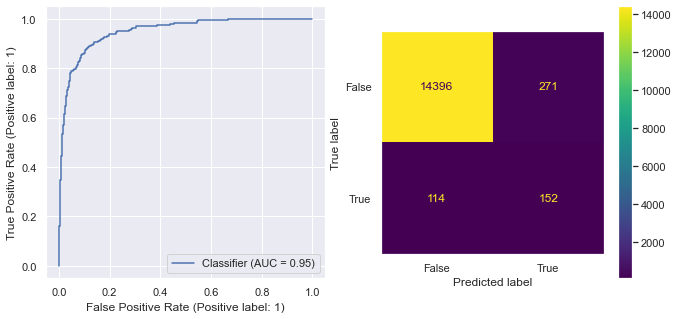

In [41]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    *sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, dropna=True),
    test_size=0.33
)

model = ImbPipeline(
    steps=[
        ("undersampling", RandomUnderSampler(sampling_strategy=0.1)),
        ("lightgbm", LGBMClassifier(metric=["l2", "auc"])),
    ]
).fit(X_train, y_train)

evaluate(model, X_test, y_test)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

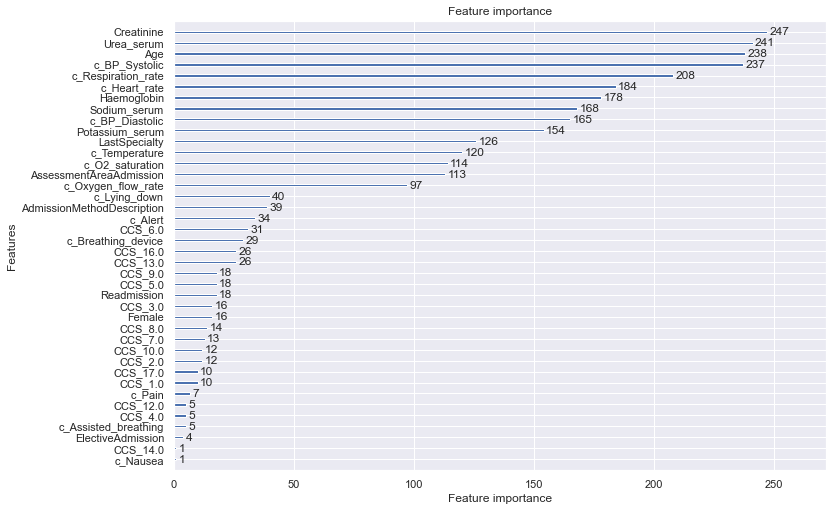

In [234]:
import lightgbm as lgb

lgb.plot_importance(model["lightgbm"])



LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


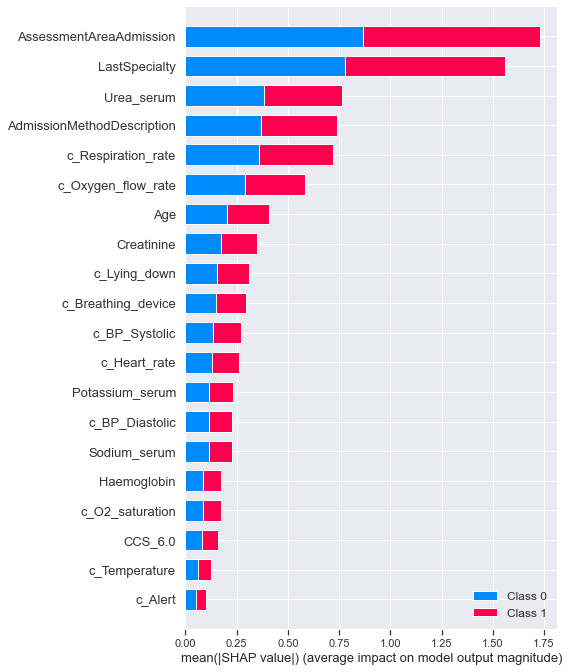

In [236]:
import shap

explainer = shap.TreeExplainer(model["lightgbm"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


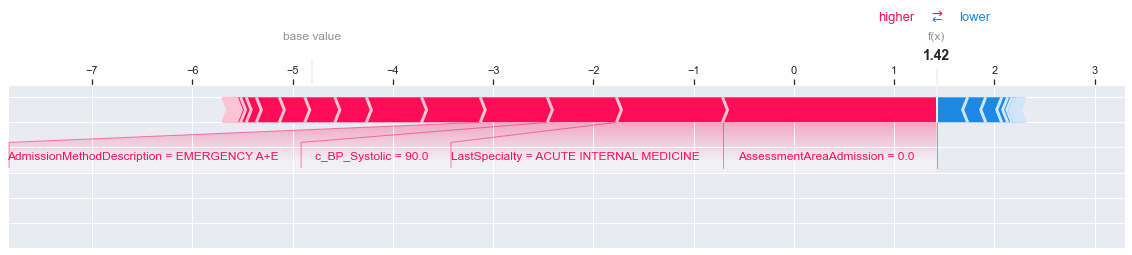

In [244]:
positive_class_idx = np.argmax(model.predict(X_test) == 1)
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][positive_class_idx, :],
    X_test.iloc[positive_class_idx],
    feature_names=X_test.columns,
    matplotlib=True,
    contribution_threshold=0.12,
)



## TabNet

In [30]:
from sklearn.metrics import fbeta_score
from pytorch_tabnet.metrics import Metric


class F2TabNet(Metric):
    def __init__(self):
        self._name = "F2"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return fbeta_score(y_true, y_pred, beta=2)


In [51]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

X, y = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
    .encode_ccs_onehot()
    .xy(outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=True)
)

categorical_cols_idx, categorical_cols_dims = X.describe_categories()

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), stratify=y, test_size=0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.33)

tabnet_params = dict(
    n_a=24,
    n_d=24,
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params=dict(step_size=50, gamma=0.9),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
)

model = TabNetClassifier(**tabnet_params)


Device used : cpu


In [52]:
model.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[
        (X_train, y_train),
        (X_valid, y_valid),
    ],
    eval_name=["train", "valid"],
    eval_metric=[F2TabNet, "auc"],
    max_epochs=300,
    patience=50,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    # augmentations = None
)


epoch 0  | loss: 0.45894 | train_F2: 0.09031 | train_auc: 0.61647 | valid_F2: 0.09615 | valid_auc: 0.65121 |  0:00:04s
epoch 1  | loss: 0.25937 | train_F2: 0.12218 | train_auc: 0.65708 | valid_F2: 0.09688 | valid_auc: 0.6126  |  0:00:09s
epoch 2  | loss: 0.18074 | train_F2: 0.12695 | train_auc: 0.69624 | valid_F2: 0.10791 | valid_auc: 0.69567 |  0:00:13s
epoch 3  | loss: 0.15205 | train_F2: 0.24885 | train_auc: 0.82089 | valid_F2: 0.24625 | valid_auc: 0.80235 |  0:00:17s
epoch 4  | loss: 0.14228 | train_F2: 0.25875 | train_auc: 0.78454 | valid_F2: 0.21442 | valid_auc: 0.76911 |  0:00:22s
epoch 5  | loss: 0.09899 | train_F2: 0.44143 | train_auc: 0.91112 | valid_F2: 0.33845 | valid_auc: 0.81276 |  0:00:26s
epoch 6  | loss: 0.0938  | train_F2: 0.62601 | train_auc: 0.97376 | valid_F2: 0.41872 | valid_auc: 0.86794 |  0:00:30s
epoch 7  | loss: 0.08049 | train_F2: 0.74098 | train_auc: 0.98921 | valid_F2: 0.42024 | valid_auc: 0.87181 |  0:00:35s
epoch 8  | loss: 0.07108 | train_F2: 0.79412 | t

### Evaluation

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.964289,0.231738,0.481675,0.861346,0.312925,0.39621


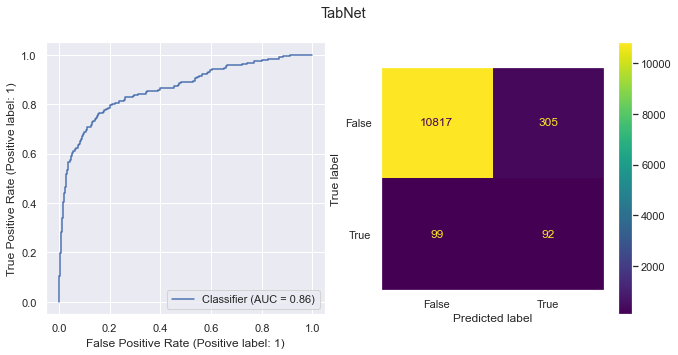

In [53]:
evaluate(model, X_test, y_test, 'TabNet')

### Explanations

<AxesSubplot:>

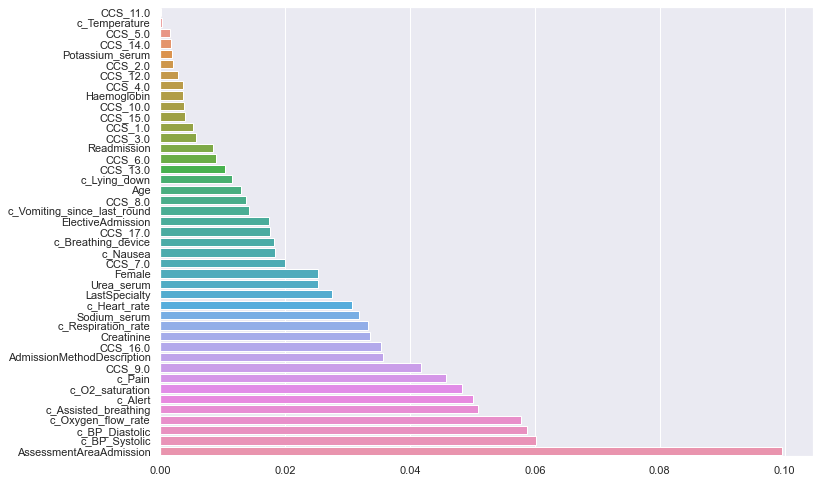

In [54]:
sorted_idx = model.feature_importances_.argsort()
sns.barplot(x=model.feature_importances_[sorted_idx], y=X.columns[sorted_idx])


In [55]:
first_idx = np.argmax(model.predict(X_test) == 1)
explain_matrix, masks = model.explain(X_test[first_idx : first_idx + 1])
list(sorted(zip(X.columns, explain_matrix[0]), key=lambda x: x[1]))


[('Female', 0.0),
 ('Age', 0.0),
 ('Haemoglobin', 0.0),
 ('Sodium_serum', 0.0),
 ('Potassium_serum', 0.0),
 ('c_Oxygen_flow_rate', 0.0),
 ('c_Temperature', 0.0),
 ('c_Alert', 0.0),
 ('c_Nausea', 0.0),
 ('c_Vomiting_since_last_round', 0.0),
 ('Readmission', 0.0),
 ('CCS_1.0', 0.0),
 ('CCS_2.0', 0.0),
 ('CCS_3.0', 0.0),
 ('CCS_4.0', 0.0),
 ('CCS_6.0', 0.0),
 ('CCS_10.0', 0.0),
 ('CCS_11.0', 0.0),
 ('CCS_12.0', 0.0),
 ('CCS_14.0', 0.0),
 ('CCS_15.0', 0.0),
 ('c_Heart_rate', 0.0003607600519899279),
 ('c_Lying_down', 0.04716101288795471),
 ('CCS_13.0', 0.06972659379243851),
 ('CCS_7.0', 0.07724221795797348),
 ('CCS_5.0', 0.09607966244220734),
 ('c_Assisted_breathing', 0.12268320471048355),
 ('CCS_8.0', 0.13649562001228333),
 ('c_BP_Diastolic', 0.14439058303833008),
 ('c_Pain', 0.15167507529258728),
 ('Urea_serum', 0.21476365625858307),
 ('LastSpecialty', 0.23033690452575684),
 ('c_O2_saturation', 0.38352254033088684),
 ('c_Respiration_rate', 0.49566924571990967),
 ('CCS_17.0', 0.61121726036

In [56]:
# spotCheckParams(TabNetClassifier(**tabnet_params), X, y, cv=3, fit_params=dict(
#     eval_metric = [F2TabNet, 'auc'],
#     max_epochs = 300, patience=50,
#     batch_size = 512, virtual_batch_size = 128,
#     num_workers = 0,
#     weights = 1,
#     drop_last = False,
# ))
